In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.auto import tqdm
import random
from torch.distributions import Categorical
import torch

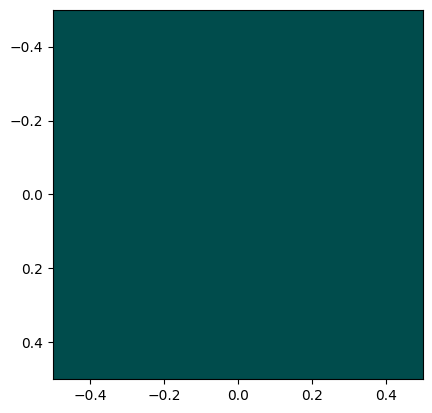

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [19]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class CustomMNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, background_color=(0, 0, 0)):
        self.original_mnist = datasets.MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )
        self.background_color = background_color
        self.mean = torch.mean(self.original_mnist.data.float()) / 255
        self.stddev = torch.std(self.original_mnist.data.float()) / 255

    def __len__(self):
        return len(self.original_mnist)

    def __getitem__(self, idx):
        image, target = self.original_mnist[idx]
        image = torch.Tensor(np.array(image))
        image = (image.float() / 255 - self.mean) / self.stddev
        a = einops.repeat(image.squeeze(0), 'h w -> c h w', c=3)
        # rr,rg,rb = random.random(), random.random(), random.random()
        # b = torch.zeros_like(a)
        # b[0] = torch.where(a[0] < 0.1 , rr, a[0])
        # b[1] = torch.where(a[1] < 0.1 , rg, a[0])
        # b[2] = torch.where(a[2] < 0.1 , rb, a[0])

        return a, target

transform = transforms.Compose([
    transforms.Resize((28, 28)),   # Resize to MNIST image size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create the custom dataset
custom_mnist = CustomMNISTDataset(
    root="./data",
    train=True,
    transform=None,
    download=True,
    background_color=(0, 0, 250)  # Blue background (change as desired)
)

In [20]:
training_dataset = CustomMNISTDataset('./data')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


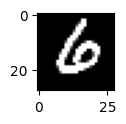

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83][0].numpy().transpose(1,2,0))
plt.show()


In [6]:
from torch.utils.data import DataLoader
import torch.nn as nn

train_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=512):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Add a batch dimension

    def forward(self, x):
        # Add the positional encodings to the input embeddings
        return x + self.encoding[:, :x.size(1)].detach()

In [8]:
import torch
import torch.nn as nn

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(LearnablePositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # Assuming x has shape [batch, len, dim]
        batch_size, seq_len, _ = x.size()

        # Broadcast positional encoding to match the shape of x
        positional_encoding = self.positional_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        
        # Mahdi Code
        #norms = torch.norm(positional_encoding, p=2, dim=2, keepdim=True)
        #positional_encoding = positional_encoding / norms


        # Add positional encoding to the input tensor
        output = x + positional_encoding

        return output

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

class SimpleSender(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleSender, self).__init__()
        self.alph_size = alph_size
        # Define your layers or modules here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=1568, out_features=64)
        self.positional_encoding = LearnablePositionalEncoding(64)
        self.rnn = nn.LSTM(64, 64, 2, batch_first=True)
        self.fc3 = nn.Linear(in_features=64, out_features=self.alph_size)


    def forward(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, l, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x, _ = self.rnn(x)
        x = self.fc3(x)
        return x

    def forward_continuous(self, x, len_message=3):
        # x = [b, 1, 1, 3] -> [b, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = einops.repeat(x, 'b d -> b l d', l = len_message)
        x = self.positional_encoding(x)
        x, _ = self.rnn(x)
        x = self.fc3(x)
        x = einops.rearrange(x, 'b l d -> b (l d)')
        return x

m1 = SimpleSender()
x = torch.randn((20, 3, 28, 28))
m1(x).shape

torch.Size([20, 3, 10])

In [10]:
class SimpleReceiver(nn.Module):
    def __init__(self, alph_size=10):
        super(SimpleReceiver, self).__init__()
        self.alph_size = alph_size
        ### Image Side
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=1568, out_features=16)
        ### Text Side
        self.emb = nn.Embedding(self.alph_size, 16)
        self.fc3 = nn.Linear(in_features=16, out_features=16)
        self.positional_encoding = LearnablePositionalEncoding(16)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=16, nhead=1, batch_first=True, dim_feedforward=32, activation=F.leaky_relu), num_layers=2)



    def forward_image(self, x):
        # x = [b, 3, 28, 28] -> [b, d]
        x = F.leaky_relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x))
        return x

    def forward_text(self, x, src_key_padding_mask=None):
        # x = [b, l] long Tensor -> [b, d]
        x = F.leaky_relu(self.emb(x))
        x = self.fc3(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # x = x.mean(dim=1)
        x = x[:,0,:]
        return x

In [11]:
def create_mask_after_end_token(input_tensor, end_token_id):
    ### [b, l] -> [b, l]
    # Find the index of the [END] token in each row
    end_token_indices = torch.nonzero(input_tensor == end_token_id)

    # Create a mask tensor of the same shape as the input tensor
    mask_tensor = torch.zeros_like(input_tensor)

    # Set elements after the [END] token index in each row to 1
    for batch_idx, end_idx in end_token_indices:
        mask_tensor[batch_idx, end_idx + 1:] = 1

    return mask_tensor
     

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
x = torch.randn((20, 3, 28, 28)).to(device)
m1 = m1.to(device)
words = m1(x).argmax(axis=2)
words_mask = create_mask_after_end_token(words, 0).bool().to(device)
m2 = SimpleReceiver().to(device)
m2.forward_text(words, words_mask).shape

torch.Size([20, 16])

In [14]:
m1 = SimpleSender(10).to(device)
m2 = SimpleReceiver(10).to(device)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3, weight_decay=0e-6)
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3, weight_decay=0e-6)

In [15]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(scale=(0.8,1),size=(28,28)),
    transforms.RandomRotation(degrees=30),
])

In [16]:
import time
from torch.distributions import Categorical
import copy

len_message = 3
eaaly_stop_acc = 0.99
max_steps = 7000
log_period_steps = 200
entropy_loss_lambda = 10e-1

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
last_acc, best_acc = 0, 0
best_model_state = None, None
for iter_num in tqdm(range(max_steps)):
  try:
    batch, _ = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch, _ = next(data_iterator)
    a = batch
  batch = batch.to(device)
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  ###
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  cosine_sim = F.cosine_similarity(m2_img_rprs.unsqueeze(1), m2_mess_rprs.unsqueeze(0), dim=2) # [batch, batch]
  batch_size = message_logits.shape[0]
  m2_loss = F.cross_entropy(cosine_sim, torch.arange(batch_size, device=device))
  m2_loss.backward()
  m2_optimizer.step()
  ###
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=2), 2, message.unsqueeze(2)))
  rewards = -1*F.cross_entropy(cosine_sim, torch.arange(batch_size, device=device), reduction='none').detach()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  #####
  temp = (1-message_mask.unsqueeze(2)*log_probs)
  temp2 = (returns.unsqueeze(1) * temp.squeeze(2))
  m1_loss = temp2.sum() / ((1-message_mask).sum())
  m1_loss = -torch.mean(returns * log_probs)
  ####
  m1_internal_repr = m1.forward_continuous(batch.float())
  contrastive_batch = transform(batch.float() + 1 * torch.randn_like(batch, device=device))
  m1_internal_repr_aug = m1.forward_continuous(contrastive_batch)
  m1_cosine_sim = F.cosine_similarity(m1_internal_repr.unsqueeze(1), m1_internal_repr_aug.unsqueeze(0), dim=2)
  m1_internal_loss = F.cross_entropy(m1_cosine_sim, torch.arange(batch.shape[0]).to(device))
  m1_loss = 1*m1_loss + 1 * m1_internal_loss
  ###
  entropy_loss = -Categorical(F.softmax(message_logits, dim=2)).entropy()
  entropy_loss_masked = (((1-message_mask)*entropy_loss)/((1-message_mask).sum())).sum()
  (m1_loss + entropy_loss_lambda*entropy_loss_masked).backward()
  m1_optimizer.step()
  acc = (cosine_sim.argmax(1) == torch.arange(batch_size, device=device)).float().mean()
  acc = (last_acc + acc)/2
  acc_list.append(acc.item())
  last_acc = acc
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(f"step {iter_num} :", acc.item())
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())
  if acc.item() > eaaly_stop_acc:
    print(f"step {iter_num} :", acc.item())
    break
  if iter_num % log_period_steps == 0:
    print(f"step {iter_num} :",rewards.mean().item(), m1_loss.item(), entropy_loss_masked.item())

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])

  0%|          | 0/7000 [00:00<?, ?it/s]

/home/mahdi/env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


step 0 : -4.158698081970215 4.158729553222656 -2.300612449645996
step 2 : 0.0078125
step 4 : 0.009765625
step 5 : 0.0205078125
step 6 : 0.02587890625
step 7 : 0.036376953125
step 10 : 0.045562744140625
step 14 : 0.04581642150878906
step 16 : 0.050516605377197266
step 18 : 0.051691651344299316
step 34 : 0.058611467480659485
step 35 : 0.06836823374032974
step 83 : 0.07029565423727036
step 84 : 0.08202283084392548
step 85 : 0.10351141542196274
step 86 : 0.10644321143627167
step 145 : 0.12852564454078674
step 200 : -3.6439061164855957 3.432457208633423 -2.2994580268859863
step 203 : 0.1309845745563507
step 209 : 0.1394978016614914
step 210 : 0.1400614082813263
step 349 : 0.14490291476249695
step 400 : -3.630847454071045 3.338472843170166 -2.2994117736816406
step 557 : 0.14571097493171692
step 600 : -3.624856948852539 3.2825584411621094 -2.2994813919067383
step 629 : 0.16123512387275696
step 691 : 0.16194815933704376
step 726 : 0.16704261302947998
step 770 : 0.1715405434370041
step 800 : -3

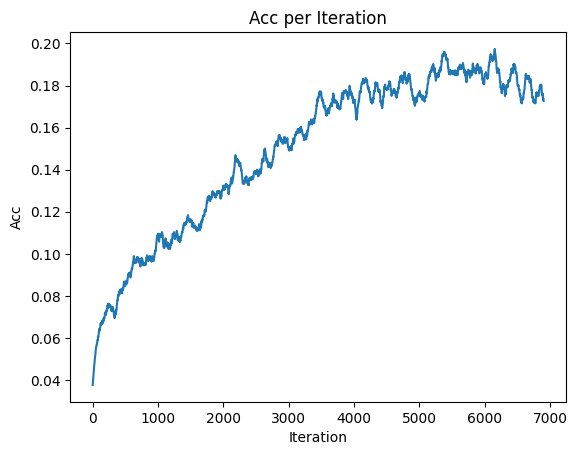

In [20]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()


In [21]:
from collections import defaultdict

messages = list()
image_dictionary = defaultdict(list)
acc_list = []

for batch, _ in tqdm(train_dataloader):
  batch = batch.to(device)
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  cosine_sim = F.cosine_similarity(m2_img_rprs.unsqueeze(1), m2_mess_rprs.unsqueeze(0), dim=2) # [batch, batch]
  batch_size = message_logits.shape[0]
  cosine_sim_shifted = torch.roll(cosine_sim, 1, 0)
  a = torch.diagonal(cosine_sim, 0)
  b = torch.diagonal(cosine_sim_shifted, 0)
  acc = (a > b).float().mean().item()
  acc_list.append(acc)
  messages.append(message)
  if len(messages) > 50:
    break
print('1-1 wining: ', sum(acc_list)/len(acc_list))


  0%|          | 0/937 [00:00<?, ?it/s]

1-1 wining:  0.9234068627450981


In [22]:
from collections import defaultdict

messages = list()
image_dictionary = defaultdict(list)

for batch, _ in tqdm(train_dataloader):
  batch = batch.to(device)
  message_logits = m1(batch.float(), len_message)
  message = message_logits.argmax(2) ### [batch, len, alph_size]
  message_mask = create_mask_after_end_token(message, 0).float()
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message, message_mask)
  cosine_sim = F.cosine_similarity(m2_img_rprs.unsqueeze(1), m2_mess_rprs.unsqueeze(0), dim=2) # [batch, batch]
  batch_size = message_logits.shape[0]
  acc = (cosine_sim.argmax(1) == torch.arange(batch_size, device=device)).float().mean().item()
  messages.append(message)
  if len(messages) > 200:
    break
  print(acc)

  for i, m in enumerate(message):
    sentence = ""
    for token in m:
      sentence = sentence + str(token.item())
      if sentence[-1] == '0':
        break
    image_dictionary[sentence].append(batch[i])


  0%|          | 0/937 [00:00<?, ?it/s]

0.21875
0.140625
0.203125
0.265625
0.109375
0.15625
0.171875
0.21875
0.21875
0.203125
0.09375
0.171875
0.171875
0.1875
0.125
0.171875
0.21875
0.15625
0.265625
0.1875
0.203125
0.265625
0.140625
0.171875
0.203125
0.15625
0.140625
0.140625
0.203125
0.265625
0.1875
0.15625
0.1875
0.171875
0.1875
0.21875
0.1875
0.15625
0.125
0.234375
0.1875
0.265625
0.15625
0.1875
0.296875
0.21875
0.21875
0.203125
0.203125
0.1875
0.125
0.21875
0.15625
0.109375
0.15625
0.203125
0.15625
0.140625
0.171875
0.140625
0.1875
0.171875
0.1875
0.15625
0.203125
0.1875
0.1875
0.21875
0.1875
0.203125
0.140625
0.234375
0.21875
0.171875
0.171875
0.203125
0.171875
0.21875
0.203125
0.203125
0.1875
0.171875
0.140625
0.171875
0.1875
0.203125
0.15625
0.171875
0.140625
0.171875
0.171875
0.171875
0.21875
0.171875
0.21875
0.171875
0.203125
0.1875
0.140625
0.203125
0.140625
0.15625
0.1875
0.1875
0.140625
0.109375
0.15625
0.1875
0.140625
0.1875
0.21875
0.1875
0.234375
0.171875
0.203125
0.234375
0.1875
0.234375
0.203125
0.171875
0.1

In [23]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

In [ ]:
import os
from datetime import datetime

# Get the current time as a datetime object
current_time = datetime.now()

# Format the current time as a string (e.g., "2023-08-13_15-30-45")
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory using the formatted time string
directory_name = time_string
os.mkdir(directory_name)

print(f"Directory '{directory_name}' created.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


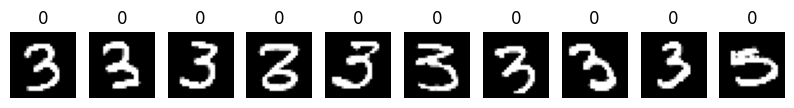

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


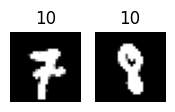

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


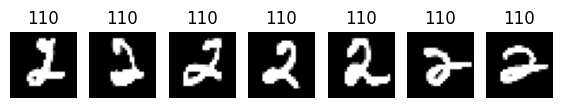

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

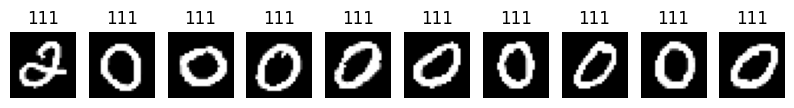

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


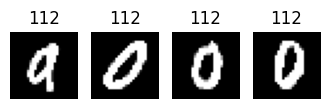

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


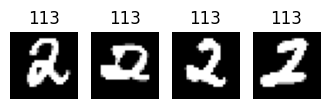

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

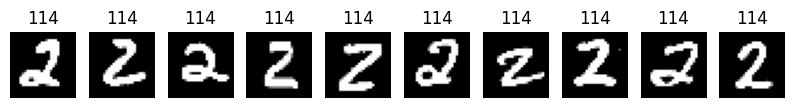

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

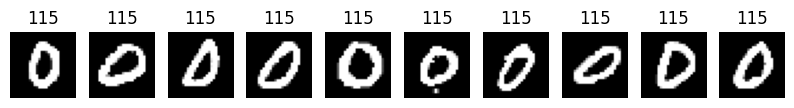

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


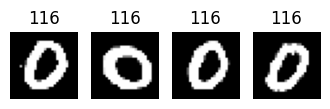

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


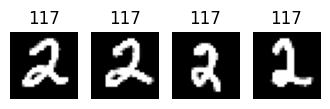

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


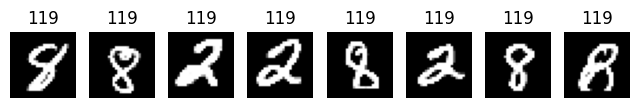

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


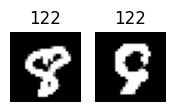

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


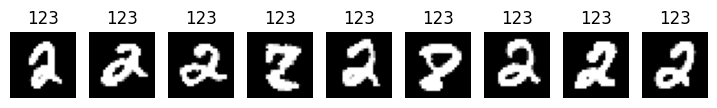

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

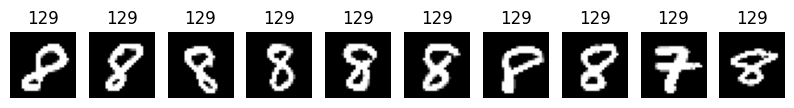

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


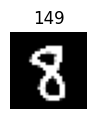

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

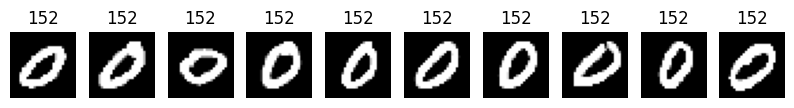

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


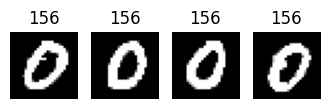

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


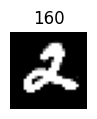

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


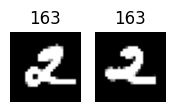

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


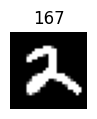

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


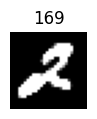

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


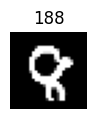

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


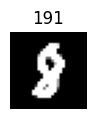

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


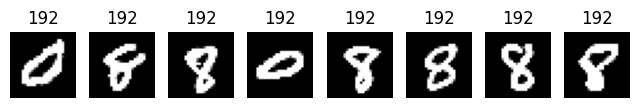

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


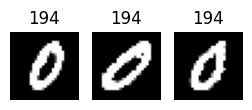

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

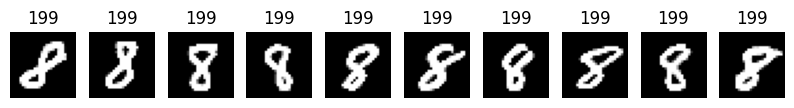

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


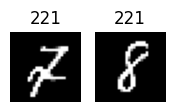

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

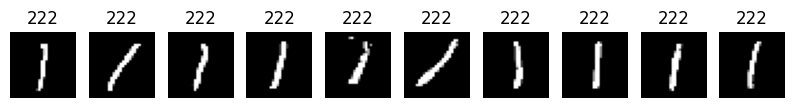

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


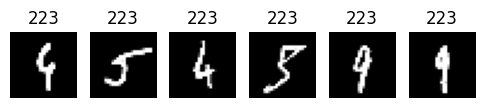

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

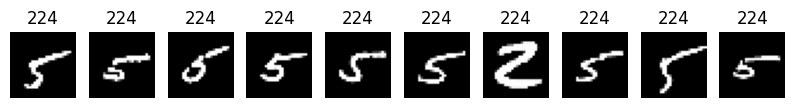

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [134]:
import matplotlib.pyplot as plt

max_image_per_token = 10
for sentence, image_indices in image_dictionary.items():
    image_indices = image_indices[:max_image_per_token]
    num_images = len(image_indices)

    if num_images == 1:
        fig = plt.figure(figsize=(1, 1))
        axs = [plt.subplot(1, 1, 1)]
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    
    for i, image in enumerate(image_indices):
        axs[i].imshow(image.cpu().numpy().transpose(1,2,0))
        axs[i].set_title(f"{sentence}")
        axs[i].axis('off')

    plt.show()
    plt.savefig(directory_name+f'/{sentence}.png')

